Epoch [1/5], Loss: 163.6905
Epoch [2/5], Loss: 47.8699
Epoch [3/5], Loss: 32.4421
Epoch [4/5], Loss: 23.8458
Epoch [5/5], Loss: 19.5408


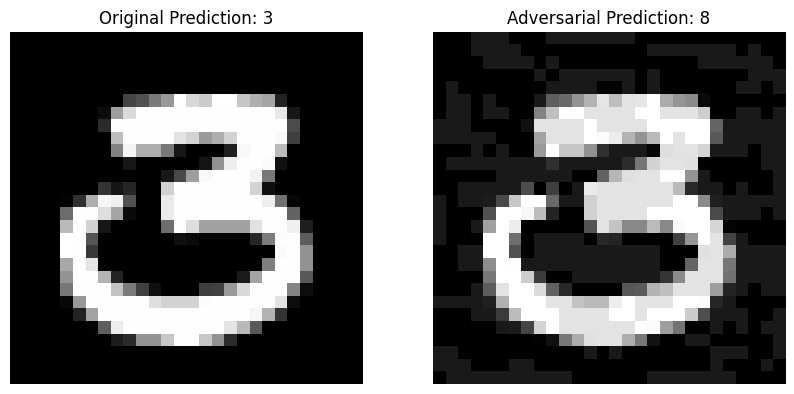

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# 1. 改善した畳み込みニューラルネットワーク(CNN)の定義
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 2. データの準備
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# 3. モデルと最適化関数の初期化
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 4. モデルの学習（5エポック）
epochs = 5
for epoch in range(epochs):
    total_loss = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch [{epoch + 1}/{epochs}], Loss: {total_loss:.4f}')

# 5. 敵対的サンプル生成関数（FGSM）
def generate_adversarial_example(model, image, label, epsilon=0.1):
    image.requires_grad = True
    output = model(image)
    loss = criterion(output, label)
    model.zero_grad()
    loss.backward()

    # ノイズ生成
    perturbation = epsilon * image.grad.sign()
    adversarial_image = image + perturbation
    adversarial_image = torch.clamp(adversarial_image, 0, 1)
    return adversarial_image

# 6. オリジナル画像と敵対的サンプルの認識結果の取得
def get_prediction(model, image):
    output = model(image)
    pred = torch.argmax(output, dim=1)
    return pred.item()

# 7. 画像の取得と表示
images, labels = next(iter(train_loader))
image, label = images[0:1], labels[0:1]

# 敵対的サンプル生成
adversarial_image = generate_adversarial_example(model, image, label)

# 認識結果取得
original_pred = get_prediction(model, image)
adversarial_pred = get_prediction(model, adversarial_image)

# 結果の表示
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image.squeeze().detach().numpy(), cmap='gray')
ax[0].set_title(f"Original Prediction: {original_pred}")
ax[0].axis('off')

ax[1].imshow(adversarial_image.squeeze().detach().numpy(), cmap='gray')
ax[1].set_title(f"Adversarial Prediction: {adversarial_pred}")
ax[1].axis('off')

plt.show()
